<a href="https://colab.research.google.com/github/rajveer100704/NYC-Taxi-Duration-Forecasting/blob/main/Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYC_Taxi_Trip_Duration_2016") \
    .getOrCreate()


In [4]:
from google.colab import files

uploaded = files.upload()

Saving nyc-taxi-trip-duration.zip to nyc-taxi-trip-duration (1).zip


In [11]:
df = spark.read.csv(f"{extracted_dir_path}/train/train.csv", header=True, inferSchema=True)
print(f"Total Rows: {df.count()}")
df.show(5)

Total Rows: 1458644
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016

In [6]:
!unzip nyc-taxi-trip-duration.zip -d nyc-taxi-trip-duration

Archive:  nyc-taxi-trip-duration.zip
  inflating: nyc-taxi-trip-duration/sample_submission.zip  
  inflating: nyc-taxi-trip-duration/test.zip  
  inflating: nyc-taxi-trip-duration/train.zip  


In [8]:
!unzip nyc-taxi-trip-duration/train.zip -d nyc-taxi-trip-duration/train

Archive:  nyc-taxi-trip-duration/train.zip
  inflating: nyc-taxi-trip-duration/train/train.csv  


In [9]:
import os

extracted_dir_path = 'nyc-taxi-trip-duration'
print(os.listdir(extracted_dir_path))

['sample_submission.zip', 'train.zip', 'train', 'test.zip']


In [10]:
extracted_dir_path = 'nyc-taxi-trip-duration'

In [12]:
from pyspark.sql.functions import unix_timestamp, col, hour, dayofweek, when

# Convert datetime columns
df = df.withColumn("pickup_ts", unix_timestamp(col("pickup_datetime")))
df = df.withColumn("dropoff_ts", unix_timestamp(col("dropoff_datetime")))

# Calculate trip duration in minutes (target)
df = df.withColumn("trip_duration_mins", (col("dropoff_ts") - col("pickup_ts")) / 60)

# Remove negative/zero durations
df = df.filter((col("trip_duration_mins") > 0) & (col("trip_duration_mins") < 120))

# Calculate distance (Haversine formula approximation)
from pyspark.sql.functions import radians, sin, cos, atan2, sqrt, lit

R = 6371  # Earth radius in km
df = df.withColumn("lat1", radians(col("pickup_latitude"))) \
       .withColumn("lon1", radians(col("pickup_longitude"))) \
       .withColumn("lat2", radians(col("dropoff_latitude"))) \
       .withColumn("lon2", radians(col("dropoff_longitude")))

df = df.withColumn("dlat", col("lat2") - col("lat1"))
df = df.withColumn("dlon", col("lon2") - col("lon1"))
df = df.withColumn("a", sin(col("dlat")/2)**2 + cos(col("lat1"))*cos(col("lat2"))*sin(col("dlon")/2)**2)
df = df.withColumn("c", 2*atan2(sqrt(col("a")), sqrt(1-col("a"))))
df = df.withColumn("trip_distance_km", R * col("c"))

# Extract time features
df = df.withColumn("pickup_hour", hour(col("pickup_datetime")))
df = df.withColumn("pickup_dayofweek", dayofweek(col("pickup_datetime")))

# Fill missing store_and_fwd_flag
df = df.na.fill({"store_and_fwd_flag": "N"})

df.select("trip_distance_km", "trip_duration_mins", "pickup_hour", "pickup_dayofweek").show(5)


+------------------+------------------+-----------+----------------+
|  trip_distance_km|trip_duration_mins|pickup_hour|pickup_dayofweek|
+------------------+------------------+-----------+----------------+
|1.4985207796469109| 7.583333333333333|         17|               2|
|1.8055071687958892|             11.05|          0|               1|
| 6.385098495252495|              35.4|         11|               3|
|1.4854984227709385|              7.15|         19|               4|
|1.1885884593338851|              7.25|         13|               7|
+------------------+------------------+-----------+----------------+
only showing top 5 rows



In [13]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Index categorical features
vendor_indexer = StringIndexer(inputCol="vendor_id", outputCol="vendor_index")
store_indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_index")

# Feature columns
feature_cols = [
    "vendor_index", "store_index", "passenger_count",
    "pickup_hour", "pickup_dayofweek", "trip_distance_km"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Build final DataFrame
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vendor_indexer, store_indexer, assembler])
df_prepared = pipeline.fit(df).transform(df)

df_prepared.select("features", "trip_duration_mins").show(5)


+--------------------+------------------+
|            features|trip_duration_mins|
+--------------------+------------------+
|[0.0,0.0,1.0,17.0...| 7.583333333333333|
|[1.0,0.0,1.0,0.0,...|             11.05|
|[0.0,0.0,1.0,11.0...|              35.4|
|[0.0,0.0,1.0,19.0...|              7.15|
|[0.0,0.0,1.0,13.0...|              7.25|
+--------------------+------------------+
only showing top 5 rows



In [14]:
train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)
print("Train:", train_df.count(), "Test:", test_df.count())


Train: 1165476 Test: 290915


In [15]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(labelCol="trip_duration_mins", featuresCol="features", numTrees=100)
rf_model = rf.fit(train_df)
rf_preds = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="trip_duration_mins", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator.evaluate(rf_preds)
print(f"Random Forest RMSE: {rf_rmse:.2f} minutes")


Random Forest RMSE: 6.96 minutes


In [16]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol="trip_duration_mins", featuresCol="features", maxIter=50)
gbt_model = gbt.fit(train_df)
gbt_preds = gbt_model.transform(test_df)

gbt_rmse = evaluator.evaluate(gbt_preds)
print(f"GBT RMSE: {gbt_rmse:.2f} minutes")


GBT RMSE: 5.93 minutes


In [17]:
from pyspark.sql.functions import col

print("Model Comparison:")
print(f"• Random Forest RMSE = {rf_rmse:.2f}")
print(f"• Gradient Boosted Trees RMSE = {gbt_rmse:.2f}")

# Display a few predictions
gbt_preds.select("trip_duration_mins", "prediction", "features").show(5)


Model Comparison:
• Random Forest RMSE = 6.96
• Gradient Boosted Trees RMSE = 5.93
+------------------+------------------+--------------------+
|trip_duration_mins|        prediction|            features|
+------------------+------------------+--------------------+
| 7.116666666666666| 9.858066043557557|[1.0,0.0,1.0,13.0...|
|              3.75|3.6972233746238086|[1.0,0.0,1.0,22.0...|
|               9.4| 5.595650820100326|[0.0,0.0,5.0,18.0...|
| 42.18333333333333|24.153002909997998|[0.0,0.0,5.0,23.0...|
| 5.316666666666666| 7.068624190621401|[0.0,0.0,5.0,20.0...|
+------------------+------------------+--------------------+
only showing top 5 rows



## Summary:

### Data Analysis Key Findings

* The distribution of trip durations and distances are both right-skewed, indicating a large number of short trips and a smaller number of longer trips.
* The scatter plot of trip distance versus trip duration shows a general positive correlation, although there is significant variability, suggesting other factors influence trip duration besides distance. The high density of points near the origin further highlights the prevalence of short trips.
* Average trip duration varies throughout the day, peaking during certain hours.
* Average trip duration also varies by day of the week, suggesting potential differences in traffic patterns or trip purposes on different days.

### Insights or Next Steps

* Further investigation into the variability in the distance-duration relationship (the spread in the scatter plot) could involve exploring other factors like time of day, day of week, or specific routes.
* Analyzing the peaks in average trip duration by hour and day of week could inform strategies for optimizing service availability or pricing during busy periods.

## Visualize trip duration by day of week

### Subtask:
Create a plot (e.g., bar plot) to show how average trip duration varies across days of the week.

**Reasoning**:
Calculate the average trip duration by day of the week and create a bar plot to visualize the result.

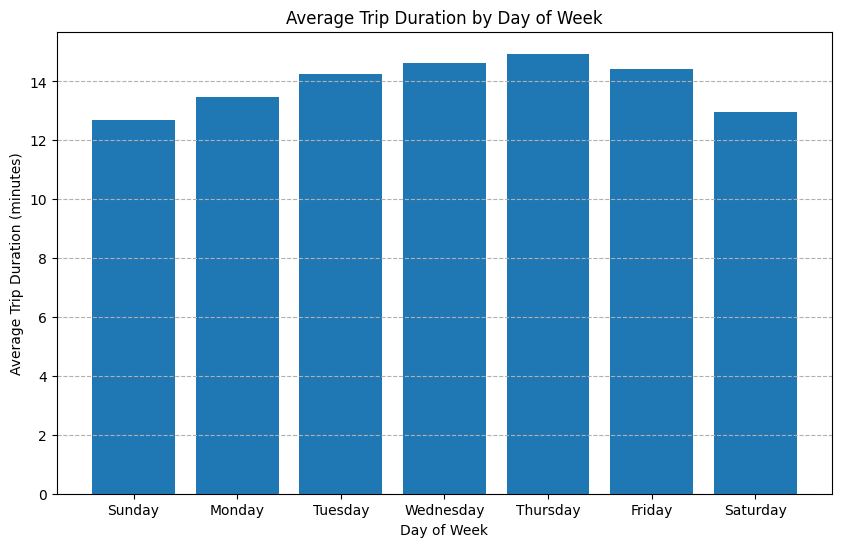

In [24]:
import matplotlib.pyplot as plt

average_duration_by_day = df_pandas.groupby('pickup_dayofweek')['trip_duration_mins'].mean()

plt.figure(figsize=(10, 6))
plt.bar(average_duration_by_day.index, average_duration_by_day.values)
plt.title('Average Trip Duration by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Trip Duration (minutes)')
plt.xticks(range(1, 8), ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.grid(axis='y', linestyle='--')
plt.show()

## Visualize trip duration by hour of day

### Subtask:
Create a plot (e.g., bar plot or line plot) to show how average trip duration varies throughout the day.

**Reasoning**:
Calculate the average trip duration by hour of day and create a bar plot to visualize the relationship.

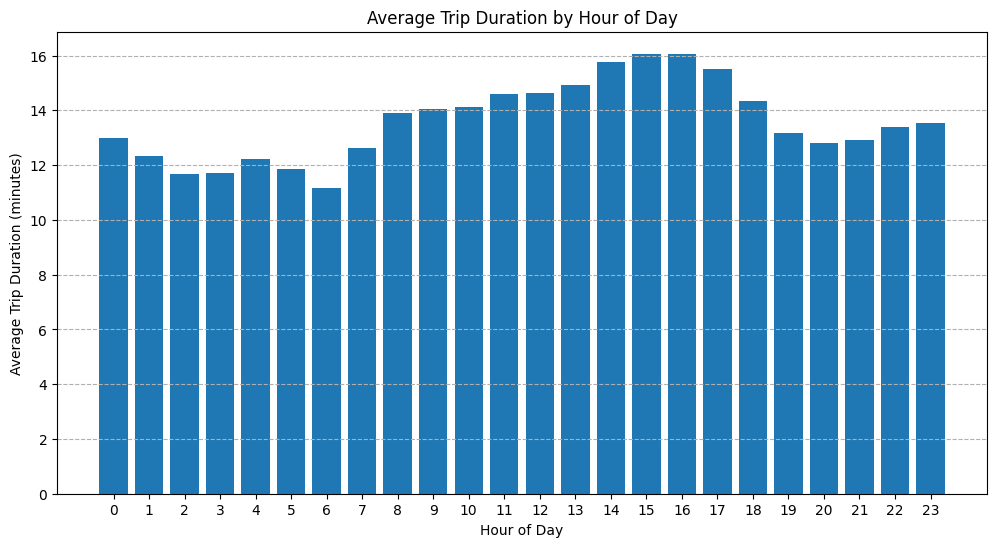

In [25]:
average_duration_by_hour = df_pandas.groupby('pickup_hour')['trip_duration_mins'].mean()

plt.figure(figsize=(12, 6))
plt.bar(average_duration_by_hour.index, average_duration_by_hour.values)
plt.title('Average Trip Duration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.xticks(range(24)) # Ensure all hours are shown on the x-axis
plt.grid(axis='y', linestyle='--')
plt.show()

## Visualize relationship between distance and duration

### Subtask:
Create a scatter plot to explore the relationship between trip distance and trip duration.

**Reasoning**:
Create a scatter plot to visualize the relationship between trip distance and trip duration using the `df_pandas` DataFrame.

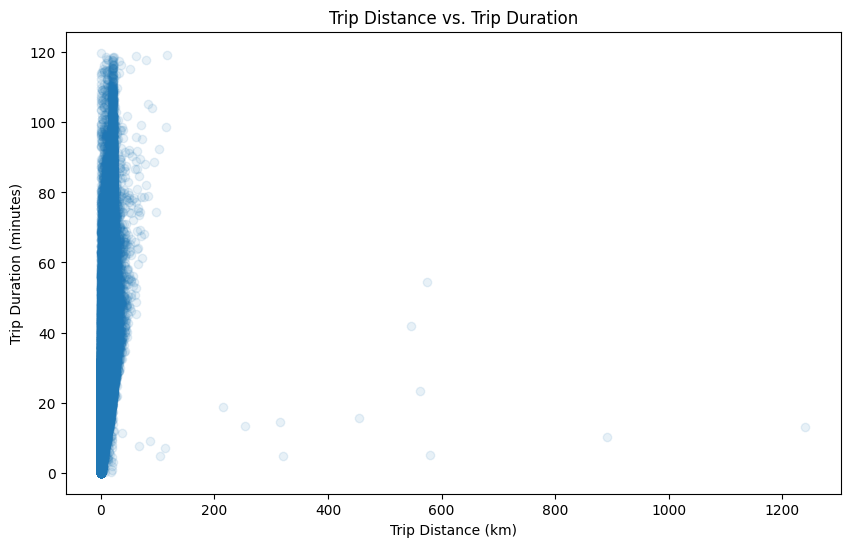

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(df_pandas['trip_distance_km'], df_pandas['trip_duration_mins'], alpha=0.1)
plt.title('Trip Distance vs. Trip Duration')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Trip Duration (minutes)')
plt.show()

# Task
Add visualizations to explore the relationships between `trip_distance_km`, `trip_duration_mins`, `pickup_hour`, and `pickup_dayofweek` in the dataframe `df`.

## Convert spark dataframe to pandas

### Subtask:
Convert the relevant columns of the Spark DataFrame to a Pandas DataFrame for easier plotting.


**Reasoning**:
Select the relevant columns from the Spark DataFrame and convert it to a Pandas DataFrame for plotting.



In [23]:
df_pandas = df.select("trip_distance_km", "trip_duration_mins", "pickup_hour", "pickup_dayofweek").toPandas()
display(df_pandas.head())

,trip_distance_km,trip_duration_mins,pickup_hour,pickup_dayofweek
0,1.498521,7.583333,17,2
1,1.805507,11.050000,0,1
2,6.385098,35.400000,11,3
3,1.485498,7.150000,19,4
4,1.188588,7.250000,13,7


## Visualize trip duration distribution

### Subtask:
Create a histogram or box plot to visualize the distribution of trip durations.


**Reasoning**:
Create a histogram to visualize the distribution of trip durations using the pandas DataFrame.



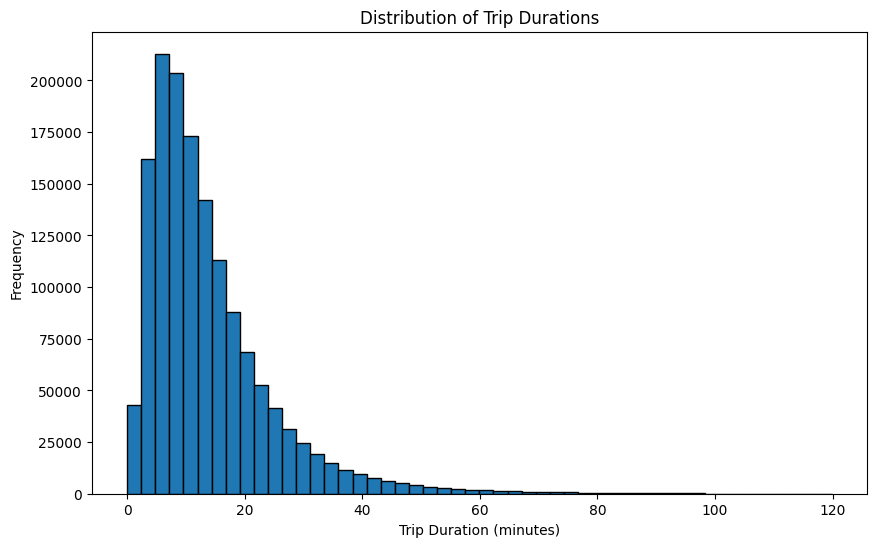

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_pandas['trip_duration_mins'], bins=50, edgecolor='black')
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

## Visualize trip distance distribution

### Subtask:
Create a histogram or box plot to visualize the distribution of trip distances.


**Reasoning**:
Generate a histogram for the distribution of trip distances using the `df_pandas` DataFrame.



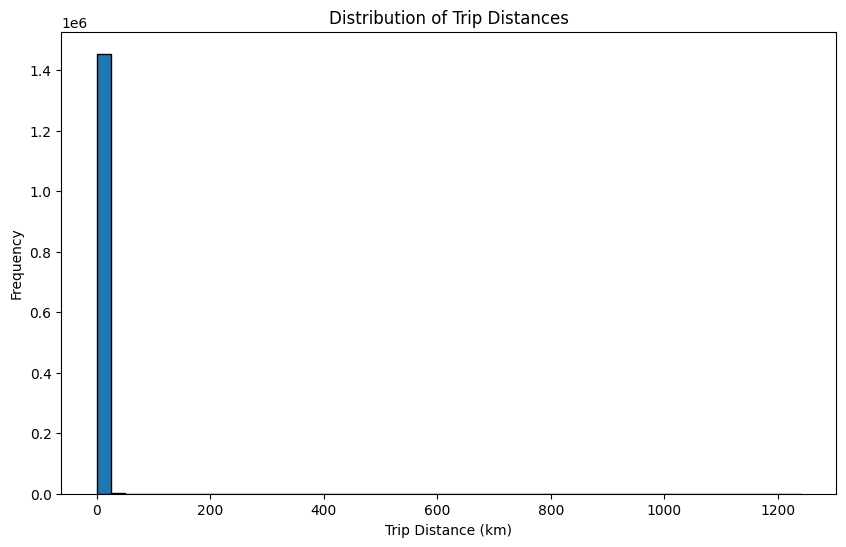

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(df_pandas['trip_distance_km'], bins=50, edgecolor='black')
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Frequency')
plt.show()

## Visualize relationship between distance and duration

### Subtask:
Create a scatter plot to explore the relationship between trip distance and trip duration.


**Reasoning**:
Create a scatter plot to visualize the relationship between trip distance and trip duration using the `df_pandas` DataFrame.



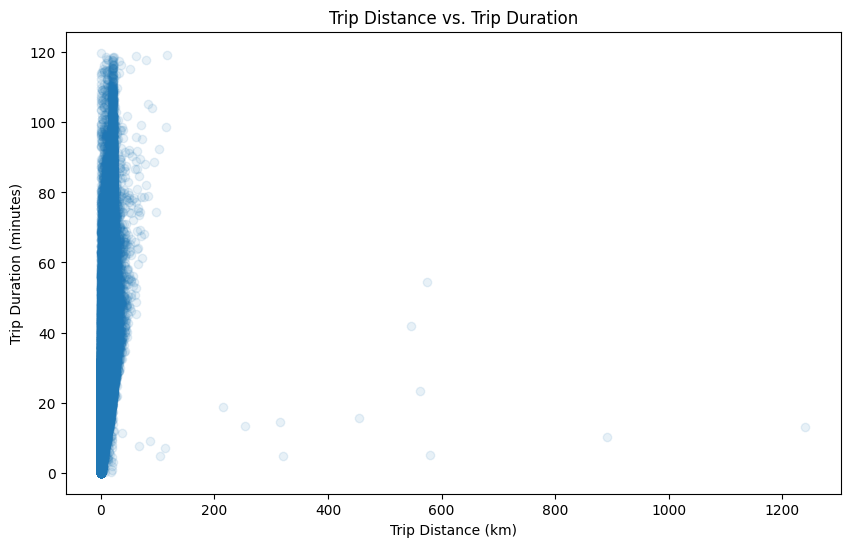

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(df_pandas['trip_distance_km'], df_pandas['trip_duration_mins'], alpha=0.1)
plt.title('Trip Distance vs. Trip Duration')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Trip Duration (minutes)')
plt.show()

## Visualize trip duration by hour of day

### Subtask:
Create a plot (e.g., bar plot or line plot) to show how average trip duration varies throughout the day.


**Reasoning**:
Calculate the average trip duration by hour of day and create a bar plot to visualize the relationship.



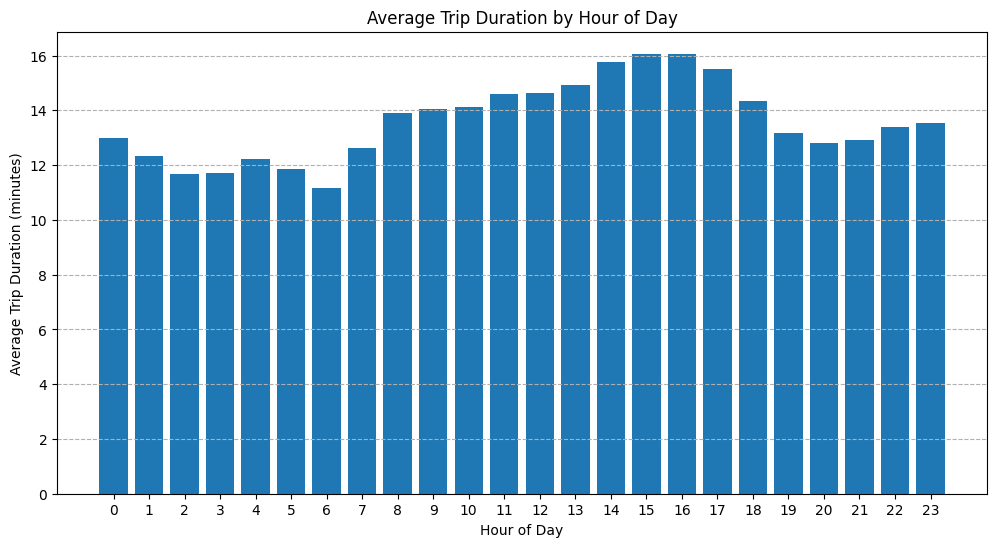

In [30]:
average_duration_by_hour = df_pandas.groupby('pickup_hour')['trip_duration_mins'].mean()

plt.figure(figsize=(12, 6))
plt.bar(average_duration_by_hour.index, average_duration_by_hour.values)
plt.title('Average Trip Duration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.xticks(range(24)) # Ensure all hours are shown on the x-axis
plt.grid(axis='y', linestyle='--')
plt.show()

## Visualize trip duration by day of week

### Subtask:
Create a plot (e.g., bar plot) to show how average trip duration varies across days of the week.


**Reasoning**:
Calculate the average trip duration by day of the week and create a bar plot to visualize the result.



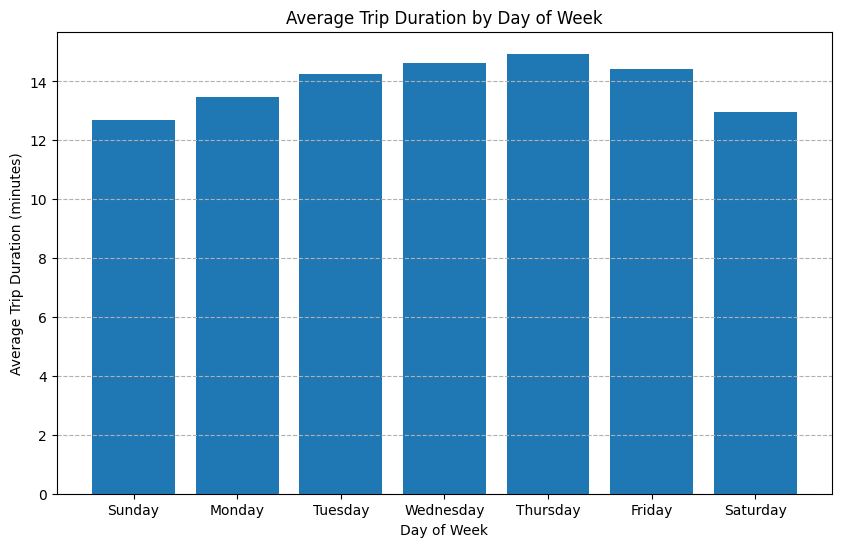

In [31]:
import matplotlib.pyplot as plt

average_duration_by_day = df_pandas.groupby('pickup_dayofweek')['trip_duration_mins'].mean()

plt.figure(figsize=(10, 6))
plt.bar(average_duration_by_day.index, average_duration_by_day.values)
plt.title('Average Trip Duration by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Trip Duration (minutes)')
plt.xticks(range(1, 8), ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.grid(axis='y', linestyle='--')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The distribution of trip durations and distances are both right-skewed, indicating a large number of short trips and a smaller number of longer trips.
*   The scatter plot of trip distance versus trip duration shows a general positive correlation, although there is significant variability, suggesting other factors influence trip duration besides distance. The high density of points near the origin further highlights the prevalence of short trips.
*   Average trip duration varies throughout the day, peaking during certain hours.
*   Average trip duration also varies by day of the week, suggesting potential differences in traffic patterns or trip purposes on different days.

### Insights or Next Steps

*   Further investigation into the variability in the distance-duration relationship (the spread in the scatter plot) could involve exploring other factors like time of day, day of week, or specific routes.
*   Analyzing the peaks in average trip duration by hour and day of week could inform strategies for optimizing service availability or pricing during busy periods.
